In [156]:
# Import Libraries

from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pylab as plt

import dmba
from dmba import regressionSummary, exhaustive_search
from dmba import backward_elimination, forward_selection, stepwise_selection
from dmba import adjusted_r2_score, AIC_score, BIC_score

from sklearn.linear_model import LinearRegression, Lasso, Ridge, LassoCV, BayesianRidge
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold #GridSearch is for hyperparameter tuning
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, LabelEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, PrecisionRecallDisplay, RocCurveDisplay, make_scorer, mean_squared_error,classification_report,confusion_matrix,ConfusionMatrixDisplay, roc_curve, auc,roc_auc_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from xgboost import XGBClassifier

%matplotlib inline

In [157]:
customers = pd.read_csv('https://raw.githubusercontent.com/delinai/schulich_ds1_2024/main/Datasets/customers_final.csv')
engagement = pd.read_csv('https://raw.githubusercontent.com/delinai/schulich_ds1_2024/main/Datasets/engagements_final.csv')
marketing = pd.read_csv('https://raw.githubusercontent.com/delinai/schulich_ds1_2024/main/Datasets/marketing_final.csv')
transactions = pd.read_csv('https://raw.githubusercontent.com/delinai/schulich_ds1_2024/main/Datasets/transactions_final.csv')

In [158]:
customers.head()

,customer_id,join_date,last_purchase_date,age,gender,location
0,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury
1,2,2021-09-08,2023-10-25,NaN,Male,Hillville
2,3,2021-06-01,2022-11-27,NaN,NaN,North Latoyatown
3,4,2022-01-01,2022-09-01,29.0,Male,Grossstad
4,5,2022-01-24,2023-06-02,NaN,Male,East Matthewfort


In [159]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   customer_id         10000 non-null  int64  
 1   join_date           10000 non-null  object 
 2   last_purchase_date  10000 non-null  object 
 3   age                 8991 non-null   float64
 4   gender              9467 non-null   object 
 5   location            10000 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 468.9+ KB


In [160]:
engagement.head()

,customer_id,number_of_site_visits,number_of_emails_opened,number_of_clicks
0,1,10,15,1
1,2,285,49,51
2,3,192,73,25
3,4,110,30,17
4,5,161,2,7


In [161]:
engagement.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 4 columns):
 #   Column                   Non-Null Count  Dtype
---  ------                   --------------  -----
 0   customer_id              10000 non-null  int64
 1   number_of_site_visits    10000 non-null  int64
 2   number_of_emails_opened  10000 non-null  int64
 3   number_of_clicks         10000 non-null  int64
dtypes: int64(4)
memory usage: 312.6 KB


In [162]:
marketing.head()

,campaign_id,customer_id,response,promotion_type,campaign_date
0,1,1,No,Buy One Get One,2024-02-29
1,2,1,No,Discount,2024-01-24
2,3,1,No,Free Shipping,2024-03-05
3,4,1,Yes,Buy One Get One,2024-01-10
4,5,2,Yes,Free Shipping,2022-07-08


In [163]:
marketing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25200 entries, 0 to 25199
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   campaign_id     25200 non-null  int64 
 1   customer_id     25200 non-null  int64 
 2   response        25200 non-null  object
 3   promotion_type  25200 non-null  object
 4   campaign_date   25200 non-null  object
dtypes: int64(2), object(3)
memory usage: 984.5+ KB


In [164]:
transactions.head()

,transaction_id,customer_id,transaction_date,transaction_amount,product_category
0,1,1,2024-02-03,165.56,Clothing
1,2,1,2024-03-02,699.01,Home Goods
2,3,1,2024-03-12,146.86,Home Goods
3,4,1,2024-01-20,927.46,Electronics
4,5,1,2024-02-25,1395.87,Electronics


In [165]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129545 entries, 0 to 129544
Data columns (total 5 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   transaction_id      129545 non-null  int64  
 1   customer_id         129545 non-null  int64  
 2   transaction_date    129545 non-null  object 
 3   transaction_amount  129545 non-null  float64
 4   product_category    129545 non-null  object 
dtypes: float64(1), int64(2), object(2)
memory usage: 4.9+ MB


In [166]:
# step 1: make transactions and marketing indexes as customer_id for easy joining
transactions.set_index('customer_id', inplace=True)
marketing.set_index('customer_id', inplace=True)

In [167]:
# we need to convert key dates to datetime objects
marketing['campaign_date'] = pd.to_datetime(marketing['campaign_date'])
transactions['transaction_date'] = pd.to_datetime(transactions['transaction_date'])

In [168]:
# Merge the customers and engagement DataFrames on 'customer_id'
merged_df = customers.merge(engagement, on='customer_id')

# Merge the result with the transactions DataFrame on 'customer_id'
transaction_level = merged_df.merge(transactions, on='customer_id')

In [169]:
transaction_level.head(15)

,customer_id,join_date,last_purchase_date,age,gender,location,number_of_site_visits,number_of_emails_opened,number_of_clicks,transaction_id,transaction_date,transaction_amount,product_category
0,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,1,2024-02-03,165.56,Clothing
1,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,2,2024-03-02,699.01,Home Goods
2,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,3,2024-03-12,146.86,Home Goods
3,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,4,2024-01-20,927.46,Electronics
4,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,5,2024-02-25,1395.87,Electronics
5,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,6,2024-01-09,174.72,Clothing
6,2,2021-09-08,2023-10-25,NaN,Male,Hillville,285,49,51,7,2022-05-05,443.99,Electronics
7,2,2021-09-08,2023-10-25,NaN,Male,Hillville,285,49,51,8,2023-01-03,492.16,Clothing
8,2,2021-09-08,2023-10-25,NaN,Male,Hillville,285,49,51,9,2021-12-11,910.21,Electronics
9,2,2021-09-08,2023-10-25,NaN,Male,Hillville,285,49,51,10,2022-10-20,42.29,Clothing


In [170]:
# merge function we'll use requires sorting
transaction_level.sort_values(by=['customer_id','transaction_date'], inplace=True)
marketing.sort_values(by=['customer_id','campaign_date'], inplace=True)

In [171]:
# make sure sorting is correct
transaction_level[transaction_level['customer_id']==1]

,customer_id,join_date,last_purchase_date,age,gender,location,number_of_site_visits,number_of_emails_opened,number_of_clicks,transaction_id,transaction_date,transaction_amount,product_category
5,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,6,2024-01-09,174.72,Clothing
3,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,4,2024-01-20,927.46,Electronics
0,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,1,2024-02-03,165.56,Clothing
4,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,5,2024-02-25,1395.87,Electronics
1,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,2,2024-03-02,699.01,Home Goods
2,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,3,2024-03-12,146.86,Home Goods


In [172]:
# make sure data type is correct
transaction_level.info()

<class 'pandas.core.frame.DataFrame'>
Index: 129545 entries, 5 to 129535
Data columns (total 13 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   customer_id              129545 non-null  int64         
 1   join_date                129545 non-null  object        
 2   last_purchase_date       129545 non-null  object        
 3   age                      116463 non-null  float64       
 4   gender                   122525 non-null  object        
 5   location                 129545 non-null  object        
 6   number_of_site_visits    129545 non-null  int64         
 7   number_of_emails_opened  129545 non-null  int64         
 8   number_of_clicks         129545 non-null  int64         
 9   transaction_id           129545 non-null  int64         
 10  transaction_date         129545 non-null  datetime64[ns]
 11  transaction_amount       129545 non-null  float64       
 12  product_category     

In [173]:
# Convert remaining dates to datetime objects
transaction_level['join_date'] = pd.to_datetime(transaction_level['join_date'])
transaction_level['last_purchase_date'] = pd.to_datetime(transaction_level['last_purchase_date'])

In [174]:
# reset index
marketing.reset_index(inplace=True)

In [175]:
# make sure sorting is correct
marketing[marketing['customer_id']==1]

,customer_id,campaign_id,response,promotion_type,campaign_date
0,1,4,Yes,Buy One Get One,2024-01-10
1,1,2,No,Discount,2024-01-24
2,1,1,No,Buy One Get One,2024-02-29
3,1,3,No,Free Shipping,2024-03-05


In [176]:
# make sure date datatype is correct
marketing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25200 entries, 0 to 25199
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   customer_id     25200 non-null  int64         
 1   campaign_id     25200 non-null  int64         
 2   response        25200 non-null  object        
 3   promotion_type  25200 non-null  object        
 4   campaign_date   25200 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 984.5+ KB


In [177]:
# Custom function to find the most recent campaign before each transaction
def find_previous_campaign(transaction_row, campaigns):
    customer_campaigns = campaigns[campaigns['customer_id'] == transaction_row['customer_id']]
    customer_campaigns = customer_campaigns[customer_campaigns['campaign_date'] <= transaction_row['transaction_date']]
    if not customer_campaigns.empty:
        return customer_campaigns.iloc[-1]  # Return the most recent campaign
    else:
        return pd.Series([None] * campaigns.shape[1], index=campaigns.columns)

# Apply the custom function to each transaction
matched_campaigns = transaction_level.apply(find_previous_campaign, axis=1, campaigns=marketing)

# Merge the matched campaigns with transactions
df_merged = transaction_level.join(matched_campaigns.add_prefix('campaign_'))

In [178]:
# merge dataframe and check customer # 1
# we can see for each transaction, now we can see if there was a marketing campaign sent to the customer before they made the transaction, and whether they responded Yes or No
# if there was NOT a marketing campaign sent to them before they made the transaction, we get missing values > hint: don't impute these.
df_merged[df_merged['customer_id']==1]

,customer_id,join_date,last_purchase_date,age,gender,location,number_of_site_visits,number_of_emails_opened,number_of_clicks,transaction_id,transaction_date,transaction_amount,product_category,campaign_customer_id,campaign_campaign_id,campaign_response,campaign_promotion_type,campaign_campaign_date
5,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,6,2024-01-09,174.72,Clothing,NaN,NaN,None,None,NaT
3,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,4,2024-01-20,927.46,Electronics,1.0,4.0,Yes,Buy One Get One,2024-01-10
0,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,1,2024-02-03,165.56,Clothing,1.0,2.0,No,Discount,2024-01-24
4,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,5,2024-02-25,1395.87,Electronics,1.0,2.0,No,Discount,2024-01-24
1,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,2,2024-03-02,699.01,Home Goods,1.0,1.0,No,Buy One Get One,2024-02-29
2,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,3,2024-03-12,146.86,Home Goods,1.0,3.0,No,Free Shipping,2024-03-05


In [179]:
# Drop duplicate customer_id column

df_merged = df_merged.drop(columns=['campaign_customer_id'])


In [180]:
# double check length of final df
len(df_merged)

129545

In [181]:
# double check marketing aligns
marketing[marketing['customer_id']==1]

,customer_id,campaign_id,response,promotion_type,campaign_date
0,1,4,Yes,Buy One Get One,2024-01-10
1,1,2,No,Discount,2024-01-24
2,1,1,No,Buy One Get One,2024-02-29
3,1,3,No,Free Shipping,2024-03-05


In [182]:
transaction_level.head()

,customer_id,join_date,last_purchase_date,age,gender,location,number_of_site_visits,number_of_emails_opened,number_of_clicks,transaction_id,transaction_date,transaction_amount,product_category
5,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,6,2024-01-09,174.72,Clothing
3,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,4,2024-01-20,927.46,Electronics
0,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,1,2024-02-03,165.56,Clothing
4,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,5,2024-02-25,1395.87,Electronics
1,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,2,2024-03-02,699.01,Home Goods


In [183]:
transaction_level['LTV'] = transaction_level.groupby('customer_id')['transaction_amount'].transform('sum')

In [184]:
transaction_level.head()

,customer_id,join_date,last_purchase_date,age,gender,location,number_of_site_visits,number_of_emails_opened,number_of_clicks,transaction_id,transaction_date,transaction_amount,product_category,LTV
5,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,6,2024-01-09,174.72,Clothing,3509.48
3,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,4,2024-01-20,927.46,Electronics,3509.48
0,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,1,2024-02-03,165.56,Clothing,3509.48
4,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,5,2024-02-25,1395.87,Electronics,3509.48
1,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,2,2024-03-02,699.01,Home Goods,3509.48


<Axes: ylabel='LTV'>

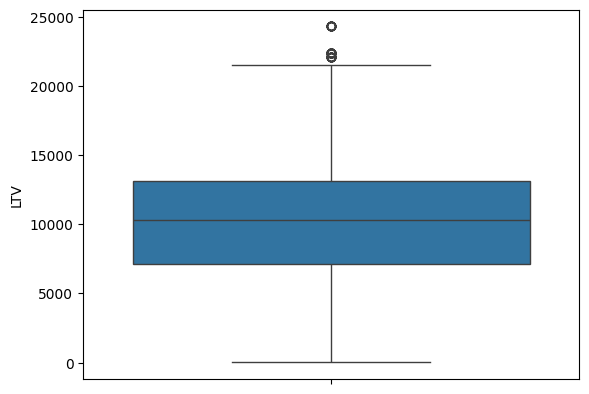

In [185]:
# Investigate outliers of ouput
sns.boxplot(transaction_level['LTV'])

In [186]:
# drop 0 LTV values (we don't want to analyze people who never bought anything)

transaction_level = transaction_level[transaction_level['LTV'] != 0]

In [187]:
# Set outliers to the 99th percentile for better modelling

# Calculate the 99th percentile of the 'transaction_amount' column
percentile_99 = transaction_level['LTV'].quantile(0.99)

# Replace values above the 99th percentile with the 99th percentile value
transaction_level['LTV'] = transaction_level['LTV'].apply(lambda x: min(x, percentile_99))


<Axes: ylabel='LTV'>

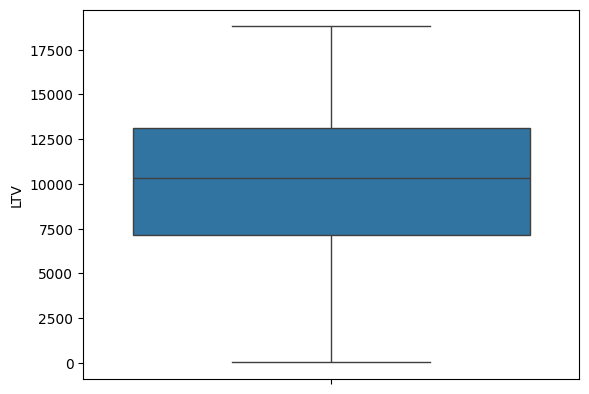

In [188]:
sns.boxplot(transaction_level['LTV'])

In [189]:
transaction_level['LTV'].describe()

count    129545.000000
mean      10096.275322
std        4078.348322
min          23.810000
25%        7134.530000
50%       10324.620000
75%       13103.090000
max       18807.100000
Name: LTV, dtype: float64

In [190]:
# Investigate appropriate Age Bins
customers['age'].describe()

count    8991.000000
mean       43.467467
std        15.094380
min        18.000000
25%        30.000000
50%        44.000000
75%        57.000000
max        69.000000
Name: age, dtype: float64

In [191]:
# Define the age bins and labels
bins = [18, 35, 50, 65, float('inf')]
labels = ['18-34', '35-49', '50-64', '65+']

# Create the age bins and label them
transaction_level['age_bins'] = pd.cut(transaction_level['age'], bins=bins, labels=labels, right=False)

In [192]:
transaction_level['age_bins'].value_counts()

age_bins
18-34    38012
50-64    34075
35-49    32940
65+      11436
Name: count, dtype: int64

In [193]:
transaction_level.info()

<class 'pandas.core.frame.DataFrame'>
Index: 129545 entries, 5 to 129535
Data columns (total 15 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   customer_id              129545 non-null  int64         
 1   join_date                129545 non-null  datetime64[ns]
 2   last_purchase_date       129545 non-null  datetime64[ns]
 3   age                      116463 non-null  float64       
 4   gender                   122525 non-null  object        
 5   location                 129545 non-null  object        
 6   number_of_site_visits    129545 non-null  int64         
 7   number_of_emails_opened  129545 non-null  int64         
 8   number_of_clicks         129545 non-null  int64         
 9   transaction_id           129545 non-null  int64         
 10  transaction_date         129545 non-null  datetime64[ns]
 11  transaction_amount       129545 non-null  float64       
 12  product_category     

In [194]:
transaction_level[transaction_level['customer_id']==1]

,customer_id,join_date,last_purchase_date,age,gender,location,number_of_site_visits,number_of_emails_opened,number_of_clicks,transaction_id,transaction_date,transaction_amount,product_category,LTV,age_bins
5,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,6,2024-01-09,174.72,Clothing,3509.48,50-64
3,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,4,2024-01-20,927.46,Electronics,3509.48,50-64
0,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,1,2024-02-03,165.56,Clothing,3509.48,50-64
4,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,5,2024-02-25,1395.87,Electronics,3509.48,50-64
1,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,2,2024-03-02,699.01,Home Goods,3509.48,50-64
2,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,3,2024-03-12,146.86,Home Goods,3509.48,50-64


In [195]:
# Create column to track customer_lifespan
transaction_level['customer_lifespan'] = transaction_level['last_purchase_date'] - transaction_level['join_date']

In [196]:
# Convert lifespan to numeric instead of timedelta

transaction_level['customer_lifespan'] = transaction_level['customer_lifespan'].dt.days

In [197]:
transaction_level[transaction_level['customer_id']==1]

,customer_id,join_date,last_purchase_date,age,gender,location,number_of_site_visits,number_of_emails_opened,number_of_clicks,transaction_id,transaction_date,transaction_amount,product_category,LTV,age_bins,customer_lifespan
5,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,6,2024-01-09,174.72,Clothing,3509.48,50-64,118
3,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,4,2024-01-20,927.46,Electronics,3509.48,50-64,118
0,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,1,2024-02-03,165.56,Clothing,3509.48,50-64,118
4,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,5,2024-02-25,1395.87,Electronics,3509.48,50-64,118
1,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,2,2024-03-02,699.01,Home Goods,3509.48,50-64,118
2,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,3,2024-03-12,146.86,Home Goods,3509.48,50-64,118


In [198]:
transaction_level.columns

Index(['customer_id', 'join_date', 'last_purchase_date', 'age', 'gender',
       'location', 'number_of_site_visits', 'number_of_emails_opened',
       'number_of_clicks', 'transaction_id', 'transaction_date',
       'transaction_amount', 'product_category', 'LTV', 'age_bins',
       'customer_lifespan'],
      dtype='object')

In [199]:
# Investigate output variable to create appropriate ranges to predict
transaction_level['LTV'].describe()

count    129545.000000
mean      10096.275322
std        4078.348322
min          23.810000
25%        7134.530000
50%       10324.620000
75%       13103.090000
max       18807.100000
Name: LTV, dtype: float64

In [200]:
# We want to predict ranges of LTV for better use in model output

# Define the LTV bins and labels
ltv_bins = [0, 7134.53, 10324.62, float('inf')]
ltv_labels = ['Low', 'Medium', 'High']

# Create the LTV_cat column in the transaction_level DataFrame
transaction_level['LTV_cat'] = pd.cut(transaction_level['LTV'], bins=ltv_bins, labels=ltv_labels, right=False)

In [201]:
transaction_level['LTV_cat'].value_counts()

LTV_cat
High      64777
Medium    32385
Low       32383
Name: count, dtype: int64

In [202]:
# Verify correct
transaction_level[transaction_level['customer_id']==1]

,customer_id,join_date,last_purchase_date,age,gender,location,number_of_site_visits,number_of_emails_opened,number_of_clicks,transaction_id,transaction_date,transaction_amount,product_category,LTV,age_bins,customer_lifespan,LTV_cat
5,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,6,2024-01-09,174.72,Clothing,3509.48,50-64,118,Low
3,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,4,2024-01-20,927.46,Electronics,3509.48,50-64,118,Low
0,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,1,2024-02-03,165.56,Clothing,3509.48,50-64,118,Low
4,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,5,2024-02-25,1395.87,Electronics,3509.48,50-64,118,Low
1,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,2,2024-03-02,699.01,Home Goods,3509.48,50-64,118,Low
2,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,3,2024-03-12,146.86,Home Goods,3509.48,50-64,118,Low


In [203]:
# Split Data for Model

X = transaction_level[['age_bins','gender','location','number_of_site_visits','number_of_emails_opened','number_of_clicks','transaction_amount','customer_lifespan']]
y = transaction_level['LTV_cat']

In [204]:
numeric_columns = ['number_of_site_visits','number_of_emails_opened','number_of_clicks','transaction_amount','customer_lifespan']
categorical_columns = ['age_bins','gender','location']

In [205]:
# reserve 30% for testing
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3)

In [206]:
# create a pre-processing pipeline which includes the steps of Scaling numeric variables and encoding categoricals
preprocessor = ColumnTransformer(
    transformers=[
        ('num',MinMaxScaler(), numeric_columns),
        ('cat',OneHotEncoder(handle_unknown='ignore',sparse_output=False),categorical_columns)
    ]
)

In [207]:
# List of models to evaluate
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'KNN': KNeighborsClassifier(),
    'Naive Bayes': GaussianNB(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier()
}

# Evaluate each model using cross-validation
for name, model in models.items():
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    scores = cross_val_score(pipeline, X_train, y_train, scoring='f1_weighted', cv=3,n_jobs=-1)
    print(f"{name} F1 Scores (weighted): {scores.mean():.3f} ± {scores.std():.3f}")

Logistic Regression F1 Scores (weighted): 0.884 ± 0.001
KNN F1 Scores (weighted): 0.948 ± 0.001
Naive Bayes F1 Scores (weighted): 0.863 ± 0.000
Decision Tree F1 Scores (weighted): 0.849 ± 0.009
Random Forest F1 Scores (weighted): 0.927 ± 0.006
